In [15]:
!pip install mne

In [16]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, LSTM, Dropout, BatchNormalization, Input, Bidirectional, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2

In [17]:
subject_ids = range(1, 51)
runs = [5, 9, 13]

X_all = []
y_all = []

In [18]:
print(f"Load data: {subject_ids}...")

for subject_id in subject_ids:
    try:
        fnames = mne.datasets.eegbci.load_data(subject_id, runs, verbose=False)
        raw = mne.io.concatenate_raws([mne.io.read_raw_edf(f, preload=True, verbose=False) for f in fnames])

        mne.datasets.eegbci.standardize(raw)

        montage = mne.channels.make_standard_montage('standard_1020')
        raw.set_montage(montage)


        # PREPROCESSING
        # Filter 0.5 - 40 Hz untuk menangkap MRCP (low freq) dan Beta (high freq)
        # serta membuang noise otot frekuensi tinggi (>40Hz)
        raw.filter(0.5, 40.0, fir_design='firwin', verbose=False)
        events, event_id = mne.events_from_annotations(raw, verbose=False)

        # Mapping label: T1 (Hands) -> 0, T2 (Feet) -> 1
        picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')

        # Epoching
        tmin, tmax = 0.5, 6.0
        epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                            baseline=None, preload=True, verbose=False)

        X = epochs.get_data()
        y = epochs.events[:, -1]

        # Konversi label agar menjadi binary 0 dan 1
        # Menormalisasi y menjadi 0 dan 1
        unique_y = np.unique(y)
        y = np.where(y == unique_y[0], 0, 1)

        X_all.append(X)
        y_all.append(y)

    except Exception as e:
        print(f"Error pada subjek {subject_id}: {e}")

Load data: range(1, 51)...


In [19]:
X = np.concatenate(X_all, axis=0)
y = np.concatenate(y_all, axis=0)

print(f"\nTotal Data Shape: {X.shape}")
print(f"Total Label Shape: {y.shape}")


Total Data Shape: (4350, 64, 881)
Total Label Shape: (4350,)


In [20]:
# Split Train & Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [21]:
# Ubah dari (Batch, Channel, Time) -> (Batch, Time, Channel)
X_train_1d = np.transpose(X_train, (0, 2, 1))
X_val_1d   = np.transpose(X_val, (0, 2, 1))
X_test_1d  = np.transpose(X_test, (0, 2, 1))

In [22]:
# Scaling (StandardScaler)
scaler = StandardScaler()

# Fungsi helper untuk scaling 3D data
def scale_data(data_3d, scaler, fit=False):
    N, T, C = data_3d.shape
    data_2d = data_3d.reshape(N * T, C)
    if fit:
        scaler.fit(data_2d)
    data_scaled_2d = scaler.transform(data_2d)
    return data_scaled_2d.reshape(N, T, C)

X_train_1d = scale_data(X_train_1d, scaler, fit=True)
X_val_1d   = scale_data(X_val_1d, scaler)
X_test_1d  = scale_data(X_test_1d, scaler)

print(f"\nShape Input Network (Train): {X_train_1d.shape}")


Shape Input Network (Train): (2784, 881, 64)


In [23]:
n_timesteps = X_train_1d.shape[1]
n_features  = X_train_1d.shape[2]

model = Sequential()
model.add(Input(shape=(n_timesteps, n_features)))

model.add(Conv1D(filters=32, kernel_size=64, padding='same', activation='elu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.3))

model.add(Conv1D(filters=64, kernel_size=32, padding='same', activation='elu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.3))

model.add(Bidirectional(LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.0)))
model.add(BatchNormalization())

model.add(LSTM(32, return_sequences=False, dropout=0.3, recurrent_dropout=0.0))
model.add(BatchNormalization())

model.add(Dense(32, activation='elu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 881, 32)        │       131,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 881, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 220, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 220, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 220, 64)        │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 220, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 55, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 55, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 55, 128)        │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 55, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,473 (1.09 MB)

 Trainable params: 284,961 (1.09 MB)

 Non-trainable params: 512 (2.00 KB)

In [24]:
opt = Adam(learning_rate=0.0005)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [25]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

In [26]:
history = model.fit(
    X_train_1d, y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_val_1d, y_val),
    callbacks=[reduce_lr, early_stop],
    verbose=1
)

Epoch 1/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.5148 - loss: 2.0572 - val_accuracy: 0.5991 - val_loss: 1.7721 - learning_rate: 5.0000e-04
Epoch 2/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5353 - loss: 1.8809 - val_accuracy: 0.6264 - val_loss: 1.6349 - learning_rate: 5.0000e-04
Epoch 3/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5837 - loss: 1.6869 - val_accuracy: 0.6149 - val_loss: 1.5250 - learning_rate: 5.0000e-04
Epoch 4/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.5613 - loss: 1.5760 - val_accuracy: 0.6178 - val_loss: 1.4044 - learning_rate: 5.0000e-04
Epoch 5/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5923 - loss: 1.4260 - val_accuracy: 0.6523 - val_loss: 1.2824 - learning_rate: 5.0000e-04
Epoch 6/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6220 - loss: 1.3003 - val_accuracy: 0.6552 - val_loss: 1.2049 - learning_rate: 5.0000e-04
Epoch 7/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy:

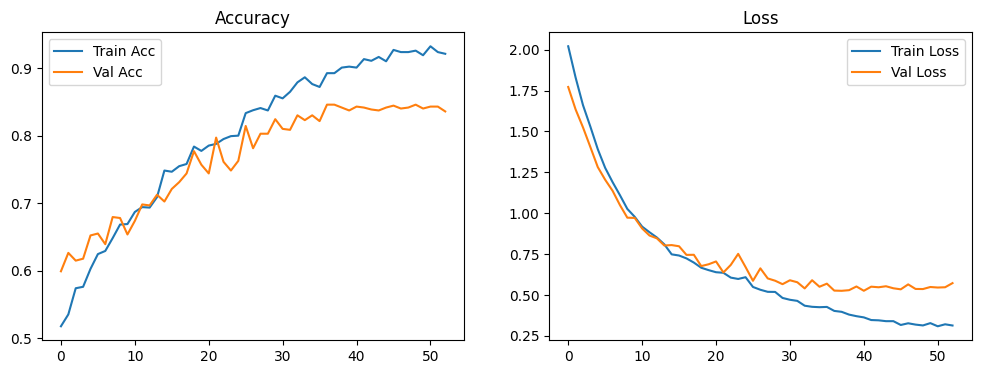

In [27]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step

--- Classification Result (Test Set) ---
                 precision    recall  f1-score   support

Class 0 (Hands)       0.85      0.87      0.86       450
 Class 1 (Feet)       0.86      0.83      0.84       420

       accuracy                           0.85       870
      macro avg       0.85      0.85      0.85       870
   weighted avg       0.85      0.85      0.85       870


--- Confusion Matrix ---


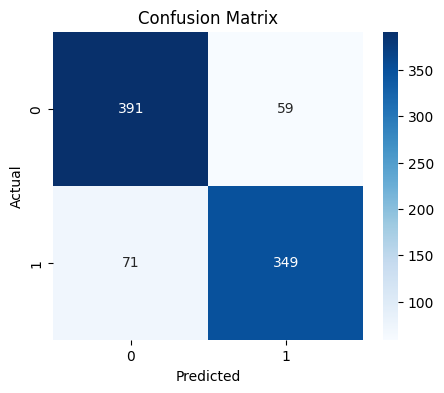

In [28]:
y_pred_proba = model.predict(X_test_1d)
y_pred = (y_pred_proba > 0.5).astype(int)

print("\n--- Classification Result (Test Set) ---")
print(classification_report(y_test, y_pred, target_names=['Class 0 (Hands)', 'Class 1 (Feet)']))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()